In [1]:
import numpy as np 
import pandas as pd

from copy import copy
from collections import Counter, defaultdict

import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay,Voronoi

import scipy.special

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

from igraph import *

from dredFISH.Analysis.TissueGraph import *
from dredFISH.Analysis.Taxonomy import *


from MERFISH_Objects.FISHData import *

import scanpy as sc

In [2]:
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
dataset = 'DPNMF_PolyA_2021Nov19'
fishdata = FISHData(os.path.join(base_path,'fishdata'))
data = fishdata.load_data('h5ad',dataset=dataset)
data.obs_names_make_unique()

data.X = data.layers['total_vectors']
data = data[np.isnan(data.X.max(1))==False]

data.X = data.X/data.obs['total_signal'][:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.X = normalize(data.X)

XY = np.asarray([data.obs['stage_y'], data.obs['stage_x']])
XY = np.transpose(XY)
data.obsm['stage'] = XY

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/tmp/ipykernel_3647123/676460092.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.X = data.X/data.obs['total_signal'][:,None]


In [3]:
TG = TissueGraph()
TG.BuildSpatialGraph(XY)

redo = False
if redo:
    celltypes = TG.TX.RecursiveLeidenWithTissueGraphCondEntropy(data.X,TG,metric = 'correlation',single_level=True)
    TG.Type = celltypes
else: 
    df = pd.read_csv('leaflabels_dev.csv')
    lbl = np.array(df,dtype='str').T
    celltypes = lbl[0]
    TG.Type = celltypes
    
TG.TX.BuildTree()

In [4]:
ZG = TG.ContractGraph() 
ZG.MaxEnvSize = 500

In [5]:
if redo: 
    (KLdiff,KL2g,KLsampling) = ZG.calcSpatialCoherencePerVertex()
else: 
    KLdiff = np.loadtxt('KLdiff_dev.txt')
    KL2g = np.loadtxt('KL2g_dev.txt')
    KLsampling = np.loadtxt('KLsampling_dev.txt')
    ZG.EnvSize = np.zeros(self.N,dbtype='int64')
    for i in range(self.N):
        ZG.EnvSize[i]=np.argmax(KLdiff[i,ZG.MinEnvSize:])+ZG.MinEnvSize
    


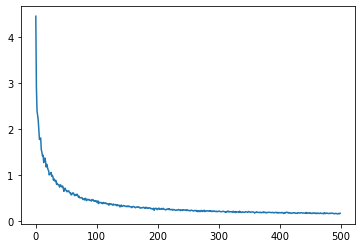

In [6]:
plt.plot(KLsampling[0,:])

In [7]:
KLmx = np.zeros(ZG.N)
KLdist = np.zeros(ZG.N)
for i in range(ZG.N): 
    KLmx[i]=np.nanmax(KLdiff[i,10:])
    KLdist[i]=np.argmax(KLdiff[i,10:])+10

KLpk = KLmx-KLdiff[:,-1]

Text(0.5, 1.0, 'cell: 4190 dist: 138 info: 0.78 pk: 0.16')

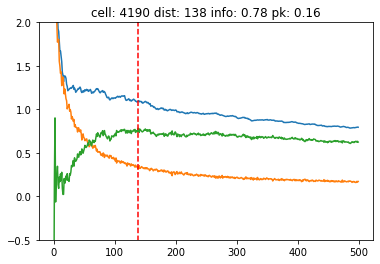

In [8]:
ix = np.random.choice(np.random.randint(KLdiff.shape[0]))

plt.plot(KL2g[ix,:])
plt.plot(KLsampling[ix,:])
plt.plot(KLdiff[ix,:])
plt.plot([KLdist[ix], KLdist[ix]],[-2, 6],'--r')
plt.ylim(-0.5,2)
plt.title(f"cell: {ix} dist: {KLdist[ix]:.0f} info: {KLmx[ix]:.2f} pk: {KLpk[ix]:.2f}")

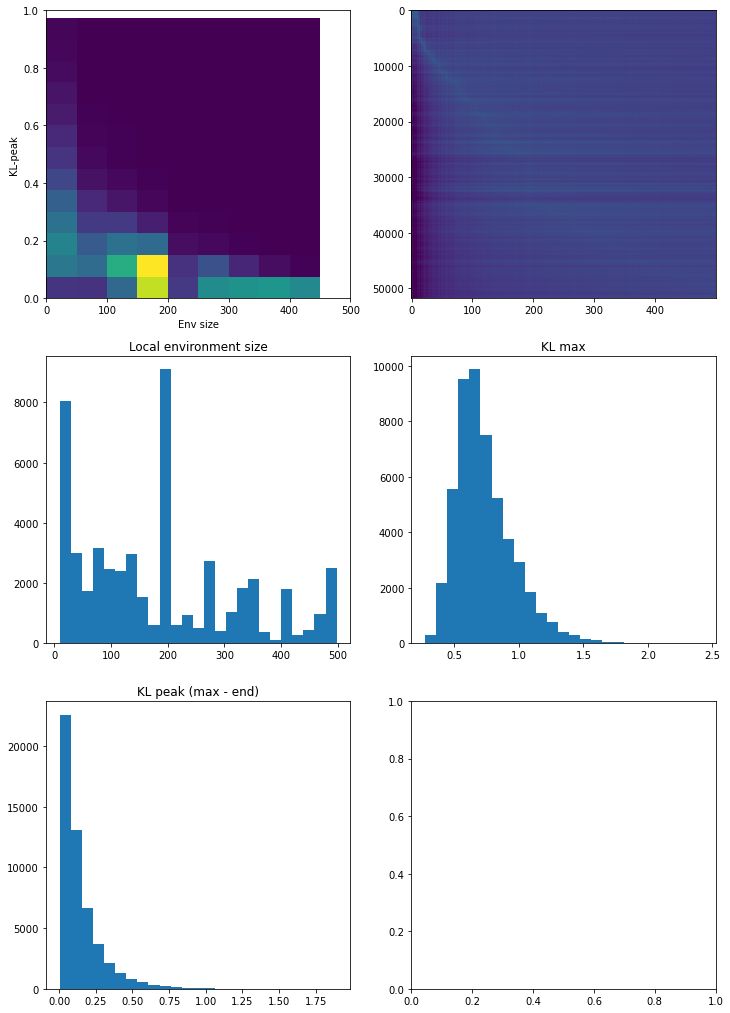

In [9]:
fig,ax = plt.subplots(3,2,figsize=(12,18))

ix=KLpk>1
ax[0,0].hist2d(KLdist,KLpk,bins=(np.arange(0, ZG.MaxEnvSize, 50), np.arange(0, 1, 0.075)))
ax[0,0].set(xlim=(0, ZG.MaxEnvSize), ylim=(0, 1))
ax[0,0].set_xlabel('Env size')
ax[0,0].set_ylabel('KL-peak')
ax[1,0].hist(KLdist,bins=25)
ax[1,0].set_title("Local environment size")

ax[1,1].hist(KLmx,bins=25)
ax[1,1].set_title("KL max")

ax[2,0].hist(KLpk,bins=25)
ax[2,0].set_title("KL peak (max - end)")

ordr = np.argsort(KLdist)

ax[0,1].imshow(KLdiff[ordr,:],aspect='auto')
im=ax[0,1].get_images()
im[0].set_clim(vmin=0, vmax=3)




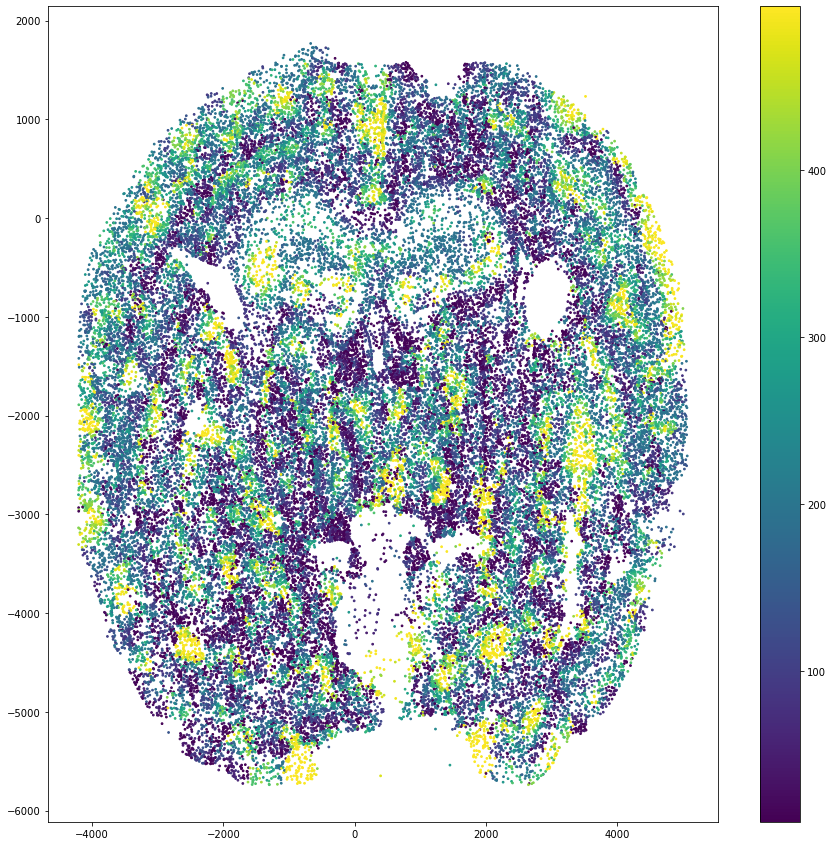

In [10]:
plt.figure(figsize=(15, 15))
plt.scatter(x=ZG.X,y=ZG.Y,c=KLdist,s=3)
plt.colorbar()

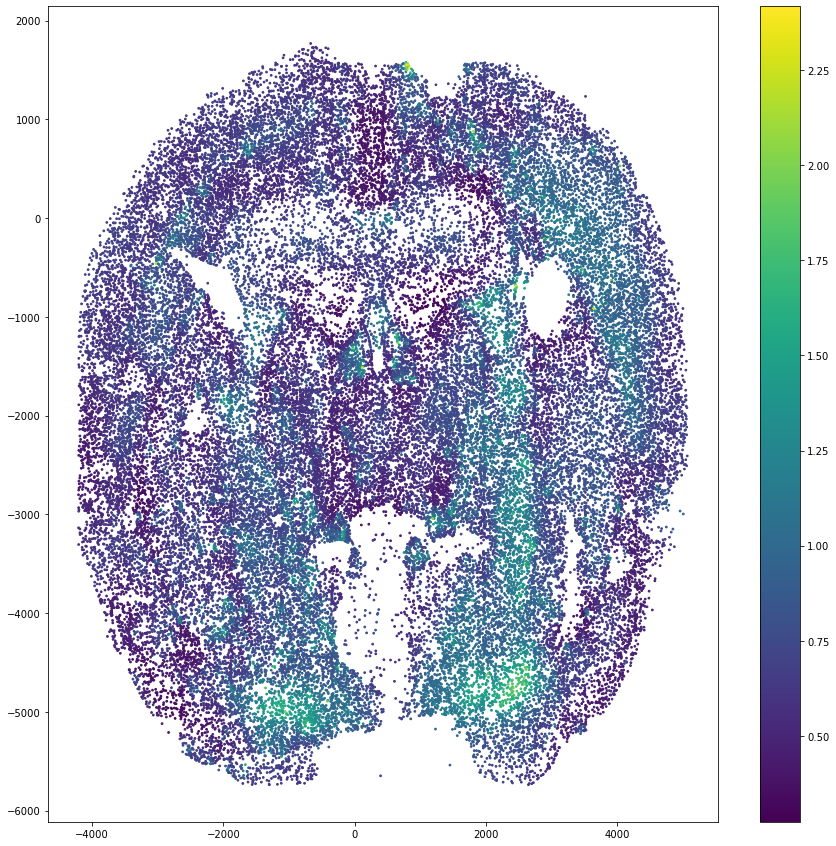

In [11]:
plt.figure(figsize=(15, 15))
plt.scatter(x=ZG.X,y=ZG.Y,c=KLmx,s=3)
plt.colorbar()

In [12]:
def extractEnvironments2(self):
    unqlbl = np.unique(self.Type)
    (distances,indices) = self.SpatialNeighbors
    Env = np.zeros((self.N,len(unqlbl)))
    for i in range(self.N):
        Env[i,:]=CountValues(self.Type[indices[i,0:self.EnvSize[i]]],unqlbl)
    
    # get treemat
    # treemat = self.TX.TreeAsMat() 
    # Env = np.matmul(Env,treemat.T)
    
    return(Env)

In [13]:
treemat = ZG.TX.TreeAsMat() 

In [20]:
ZG.EnvSize

In [15]:
treemat[123,:].sum()

1.0

In [26]:
Env = ZG.extractEnvironments()
Env.shape

(51761, 190)

In [25]:
Env2 = extractEnvironments2(ZG)
Env2.shape

(51761, 96)

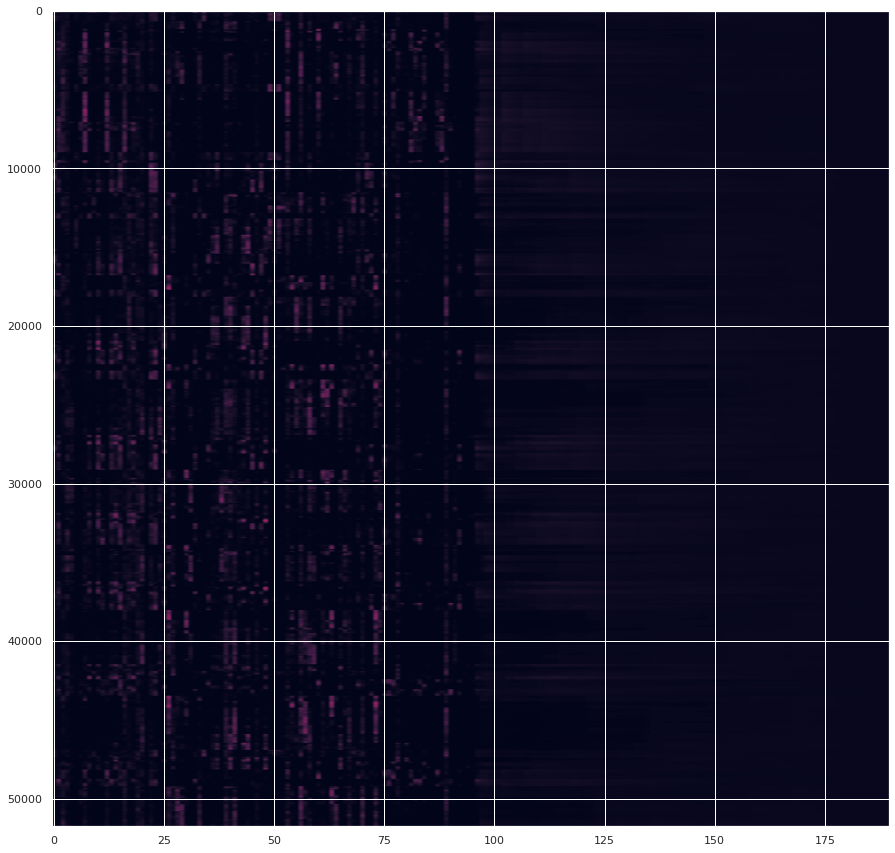

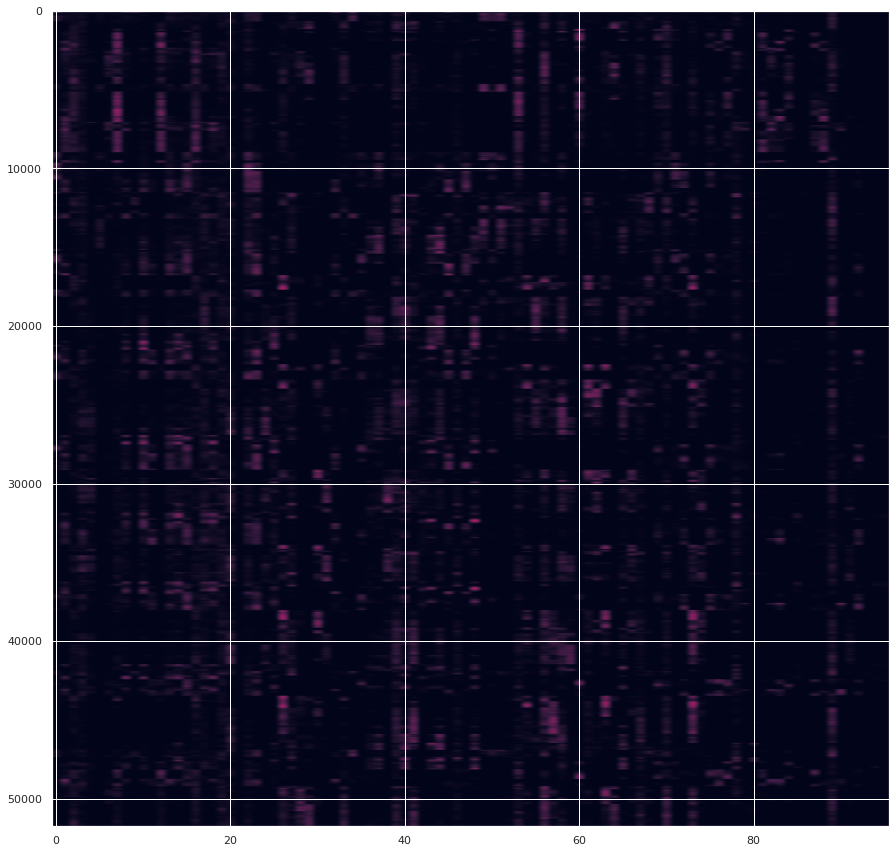

In [103]:
plt.figure(figsize=(15, 15))
plt.imshow(Env,aspect='auto')
im=plt.gca().get_images()
im[0].set_clim(vmin=0, vmax=0.5)



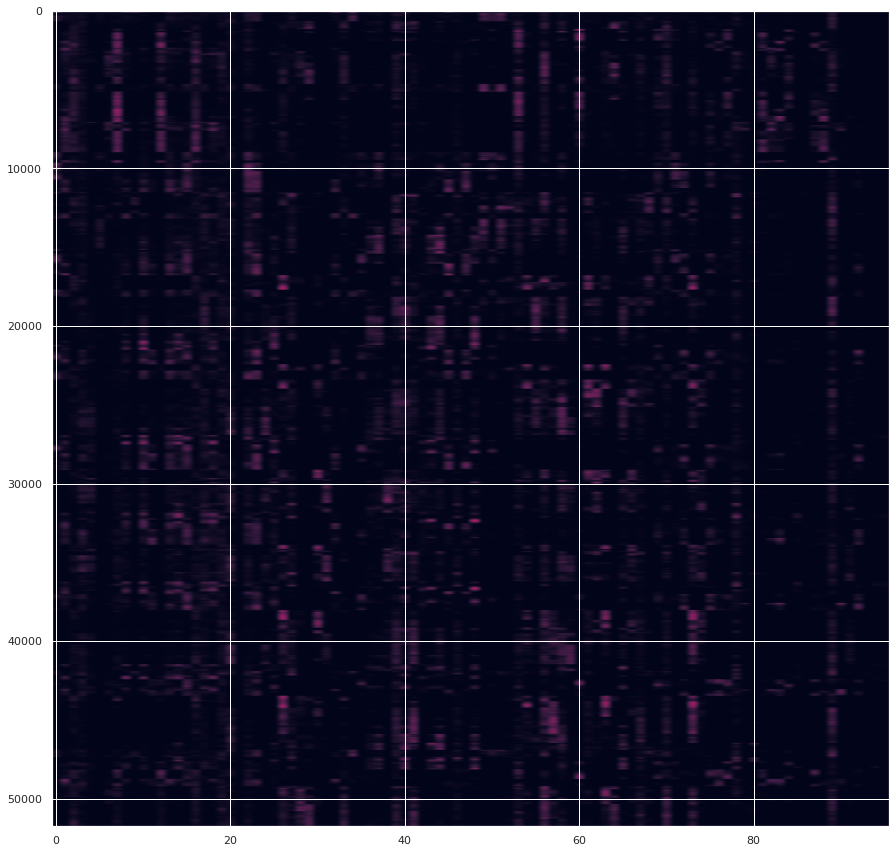

In [104]:
plt.figure(figsize=(15, 15))
plt.imshow(Env[:,0:96],aspect='auto')
im=plt.gca().get_images()
im[0].set_clim(vmin=0, vmax=0.5)

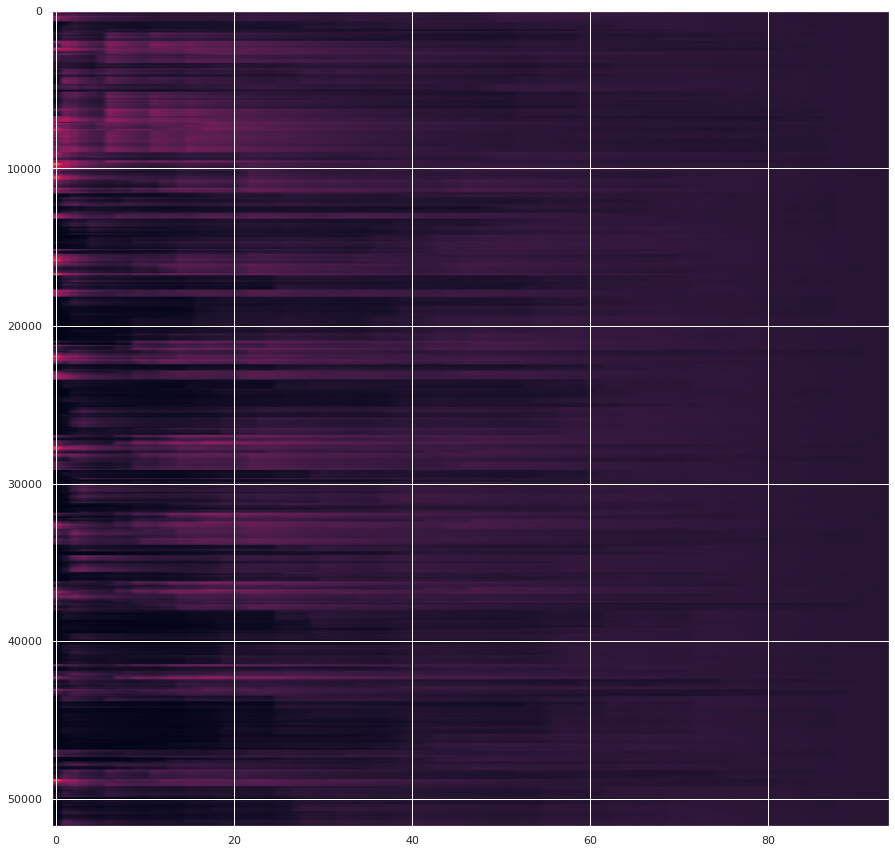

In [107]:
plt.figure(figsize=(15, 15))
plt.imshow(Env[:,96:],aspect='auto')
im=plt.gca().get_images()
im[0].set_clim(vmin=0, vmax=0.1)

In [82]:
from scipy.spatial.distance import jensenshannon

In [28]:
envtypes = ZG.TX.RecursiveLeidenWithTissueGraphCondEntropy(Env,ZG,metric = 'correlation',single_level=True)

Build similarity graph 
calculation took: 13.46
Calling initial optimization
 
 Func-count     x          f(x)          Procedure
    1        11.5208    -0.800201        initial
    2        18.5792    -0.859778        golden
    3        22.9416     -0.87005        golden
    4        22.9698    -0.865556        parabolic
    5        20.7924    -0.893017        parabolic
    6         19.947    -0.873977        golden
    7        21.3852    -0.864003        parabolic
    8        20.4695    -0.857497        golden
    9        21.0188    -0.883275        golden
   10        20.5538    -0.868469        parabolic
   11        20.7013    -0.868894        golden
   12        20.8789    -0.868486        golden
   13        20.7576    -0.860875        golden
   14        20.8254    -0.874571        golden
   15        20.7791    -0.878058        golden
   16         20.805    -0.870472        golden
   17        20.7873    -0.857436        golden
   18        20.7972    -0.862627        

In [99]:


myenvtype[EG.UpstreamMap[ZG.UpstreamMap]]

97786

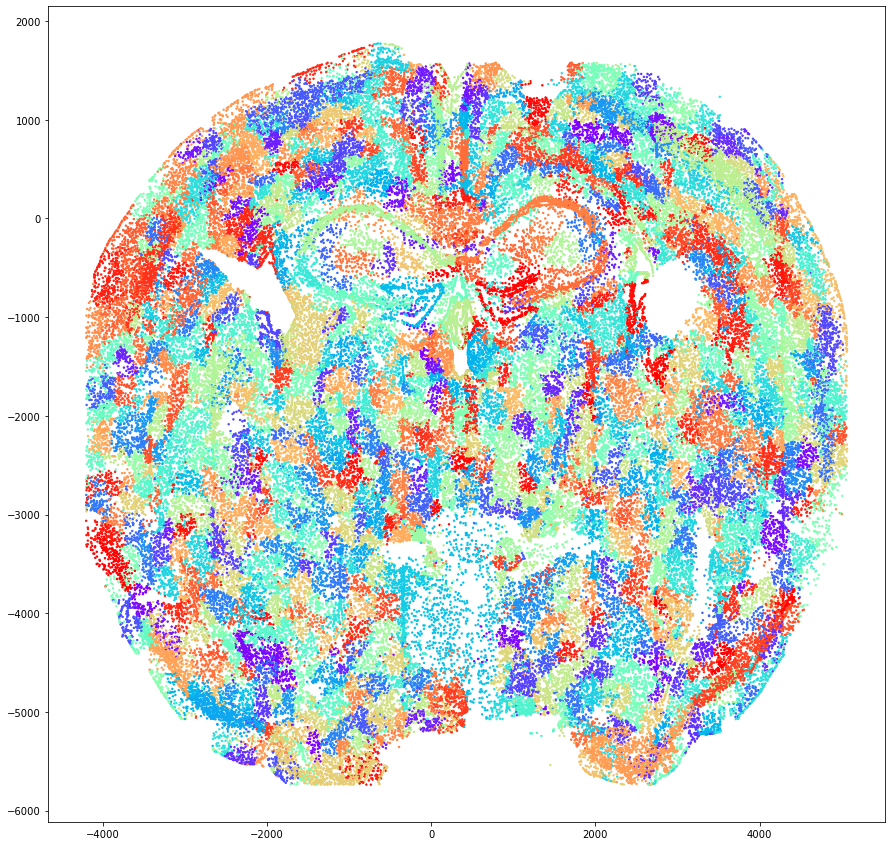

In [101]:
import matplotlib.cm as cm

myenvtype = EG.Type.astype(np.int64)
myenvtype = myenvtype[EG.UpstreamMap[ZG.UpstreamMap]]

unqenv = np.unique(myenvtype)
colors = cm.rainbow(np.linspace(0, 1, len(unqenv)))
colors = colors[np.random.permutation(colors.shape[0]),:]
envcolors = colors[myenvtype,:]
plt.figure(figsize=(15, 15))

plt.scatter(x=TG.X,y=TG.Y,s=2,c=envcolors)
plt.show()

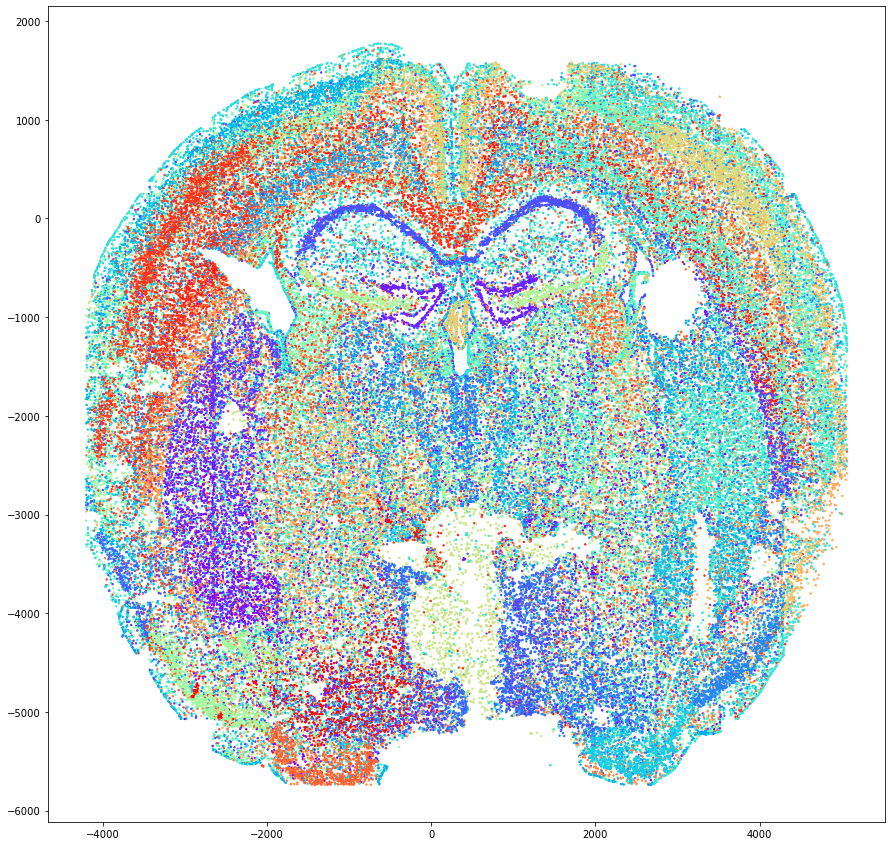

In [90]:
myenvtype = TG.Type.astype(np.int64)

unqenv = np.unique(myenvtype)
colors = cm.rainbow(np.linspace(0, 1, len(unqenv)))
colors = colors[np.random.permutation(colors.shape[0]),:]
envcolors = colors[myenvtype,:]
plt.figure(figsize=(15, 15))

plt.scatter(x=TG.X,y=TG.Y,s=2,c=envcolors)
plt.show()

In [112]:
agraph = buildgraph(Env)

0.1
0.14677992676220694
0.21544346900318834
0.31622776601683794
0.46415888336127786
0.6812920690579611
1.0
1.467799267622069
2.1544346900318834
3.1622776601683795
4.6415888336127775
6.812920690579611
10.0
14.67799267622069
21.54434690031882
31.622776601683793
46.41588833612777
68.12920690579608
100.0
146.7799267622069
215.44346900318823
316.22776601683796
464.15888336127773
681.2920690579608
1000.0


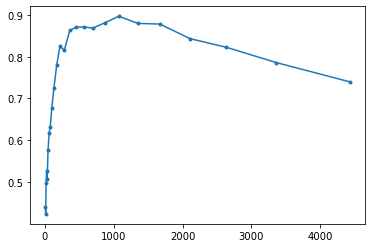

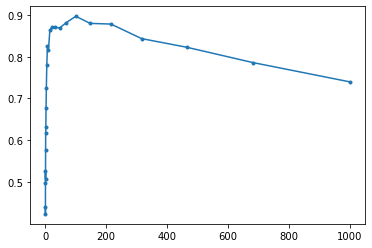

In [113]:
Rvec = np.logspace(-1,3,25)
ntypes = list()
entlist = list()

for res in Rvec:
    print(res)
    envtype3 = agraph.community_leiden(resolution_parameter=res,objective_function='modularity').membership
    envtype3 = np.array(envtype3,dtype=np.int64)
    entlist.append(ZG.ContractGraph(envtype3).CondEntropy())
    ntypes.append(max(envtype3))

plt.plot(ntypes,entlist,'.-')
plt.figure()
plt.plot(Rvec,entlist,'.-')

In [114]:
envtype3 = agraph.community_leiden(resolution_parameter=Rvec[np.argmax(np.array(entlist))],objective_function='modularity').membership
envtype3 = np.array(envtype3,dtype=np.int64)

In [115]:
max(envtype3)

1082

(array([1061., 1012.,  913., 1008., 1088.,  971.,  859., 1134., 1092.,
        1006., 1041.,  981., 1065.,  973., 1091., 1086., 1039., 1033.,
        1217.,  979., 1017., 1066.,  928.,  976., 1125., 1109., 1044.,
        1096., 1112.,  984., 1062., 1088., 1047., 1168.,  955.,  991.,
         996.,  992.,  953., 1051., 1039.,  940., 1084.,  957., 1042.,
        1091., 1053., 1073.,  990., 1083.]),
 array([   0.  ,   21.56,   43.12,   64.68,   86.24,  107.8 ,  129.36,
         150.92,  172.48,  194.04,  215.6 ,  237.16,  258.72,  280.28,
         301.84,  323.4 ,  344.96,  366.52,  388.08,  409.64,  431.2 ,
         452.76,  474.32,  495.88,  517.44,  539.  ,  560.56,  582.12,
         603.68,  625.24,  646.8 ,  668.36,  689.92,  711.48,  733.04,
         754.6 ,  776.16,  797.72,  819.28,  840.84,  862.4 ,  883.96,
         905.52,  927.08,  948.64,  970.2 ,  991.76, 1013.32, 1034.88,
        1056.44, 1078.  ]),
 <BarContainer object of 50 artists>)

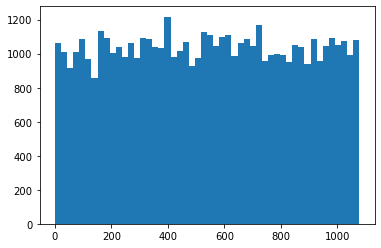

In [110]:
Counter(envtype3)

plt.hist(envtype3,bins=50)

In [72]:
EG = ZG.ContractGraph(envtype3)

In [83]:
print(mean(EG.NodeSize>10))
print(sum(EG.NodeSize[EG.NodeSize>10])/ZG.N)

0.18557504873294325
0.8646664477115975


(array([3.814e+03, 1.900e+02, 1.330e+02, 4.100e+01, 4.500e+01, 3.800e+01,
        2.200e+01, 4.400e+01, 1.700e+01, 2.500e+01, 3.400e+01, 2.000e+01,
        2.200e+01, 4.100e+01, 3.800e+01, 3.600e+01, 3.000e+01, 2.600e+01,
        4.100e+01, 2.800e+01, 4.200e+01, 2.700e+01, 2.600e+01, 4.300e+01,
        2.800e+01, 3.100e+01, 3.200e+01, 2.100e+01, 2.900e+01, 1.800e+01,
        3.100e+01, 3.200e+01, 1.200e+01, 9.000e+00, 1.500e+01, 7.000e+00,
        1.500e+01, 3.000e+00, 1.000e+00, 4.000e+00, 6.000e+00, 2.000e+00,
        5.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   3.38,   5.76,   8.14,  10.52,  12.9 ,  15.28,  17.66,
         20.04,  22.42,  24.8 ,  27.18,  29.56,  31.94,  34.32,  36.7 ,
         39.08,  41.46,  43.84,  46.22,  48.6 ,  50.98,  53.36,  55.74,
         58.12,  60.5 ,  62.88,  65.26,  67.64,  70.02,  72.4 ,  74.78,
         77.16,  79.54,  81.92,  84.3 ,  86.68,  89.06,  91.44,  93.82,
         96.2 , 

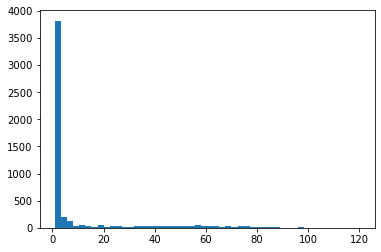

In [77]:
plt.hist(EG.NodeSize,bins=50)

In [102]:
EG.EnvSize
SecEnv = EG.extractEnvironments()

TypeError: 'NoneType' object is not subscriptable

In [92]:
from numba import njit

@njit
def JSD(P,Q):
    """
    calculate JSD distances between P and Q
    """
    M=P+Q/2
    logM = np.log2(M)
    logP = np.log2(P)
    logQ = np.log2(Q)
    
    JSD = 0
    for i in range(len(P)):
        if P[i]>0:
            JSD += 0.5*(P[i]*(logP[i]-logM[i]))
        if Q[i]>0:
            JSD += 0.5*(Q[i]*(logQ[i]-logM[i]))

    return JSD

In [ ]:
from numba import njit

@njit
def symKL(P,Q):
    """
    calculate symmetric KL distances between P and Q
    """
    logP = np.log2(P)
    logQ = np.log2(Q)
    
    symKL = 0
    for i in range(len(P)):
        if P[i]>0:
            JSD += 0.5*(P[i]*(logP[i]-logM[i]))
        if Q[i]>0:
            JSD += 0.5*(Q[i]*(logQ[i]-logM[i]))

    return JSD

In [94]:
j1=JSD(Env[0,:],Env[1,:])
from scipy.spatial.distance import jensenshannon
j2=jensenshannon(Env[0,:],Env[1,:])
print(f"numba: {j1:.3f} scipy:{j2:.3f}")

numba: -1.355 scipy:0.176


In [ ]:
%%time
index = pynndescent.NNDescent(Env, metric=JSD,n_neighbors=15)